In [31]:
import os
import numpy as np
import pandas as pd
import pickle
# import sklearn.linear_model as sklm
# import sklearn.model_selection as skms
# import sklearn.feature_selection
import sklearn.pipeline
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Import our custom functions
from load_data import load_data 

Load training and validation data:

x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)

y is a dataframe of index, class_name and class_id

In [2]:

x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


Plot a random image from the validation data for each category

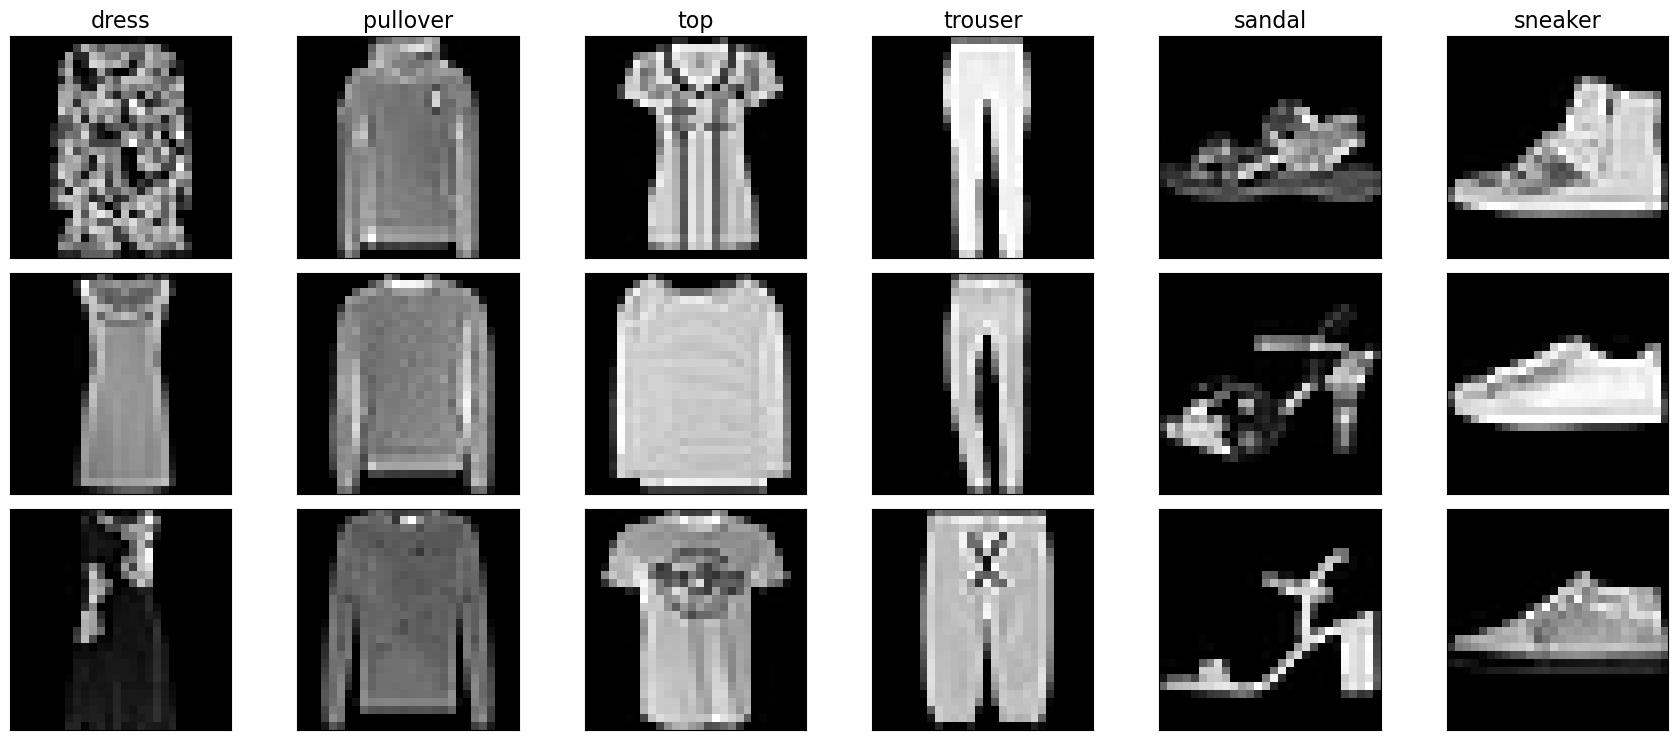

In [4]:
# prng = np.random.RandomState(0)
prng = np.random.RandomState()
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = y_va_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = x_va[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
plt.tight_layout();
plt.show();

# Data Exploration 1a

In [5]:
tr_class_dist = y_tr_df['class_name'].value_counts()
val_class_dist = y_va_df['class_name'].value_counts()

print('Training class distribution:')
print(tr_class_dist)
print('Validation class distribution:')
print(val_class_dist)

Training class distribution:
sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
Name: class_name, dtype: int64
Validation class distribution:
dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
Name: class_name, dtype: int64


The training data is heavily skewed with data from sandals and trainers, with only one training image for 2 classes. A challenge will be gaining a balanced weighting for each of the classes such that the dominant classes aren't always favoured by the classifier.

# Model

Run search with predefined split s.t. validation set is used for hyperparameter selection

In [6]:
# Combine training and validation datasets
x_all = np.vstack((x_tr,x_va))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr.shape, x_va.shape, x_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


In [7]:
param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

fashion_pipes = sklearn.pipeline.Pipeline([
    ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1, refit=False))
])

fashion_pipes.fit(x_all, y_all_df['class_name'])

Pipeline(steps=[('rand_search',
                 RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                                    error_score='raise',
                                    estimator=MLPClassifier(early_stopping=True,
                                                            random_state=0,
                                                            solver='lbfgs'),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'activation': ['relu',
                                                                        'logistic',
                                                                        'identity',
                                                                        'tanh'],
                                                         'hidden_layer_sizes': [(20,),
                                                                                (50,),
                                                                                (100,),
                                                                                (200,),
                                                                                (500,)],
                                                         'le...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
                                    random_state=0, refit=False,
                                    return_train_score=True,
                                    scoring='balanced_accuracy'))])

In [58]:
gridRes = fashion_pipes['rand_search'].cv_results_
bestIdx = fashion_pipes['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
bestParams[0] = {k:v[bestIdxs[0]] for k,v in gridRes.items()}
bestParams[1] = {k:v[bestIdxs[1]] for k,v in gridRes.items()}
bestParams[2] = {k:v[bestIdxs[2]] for k,v in gridRes.items()}

display(bestParams)
# print(gridRes["mean_test_score"])
# display(gridRes["mean_test_score"])

{0: {'mean_fit_time': 85.59718680381775,
  'std_fit_time': 0.0,
  'mean_score_time': 0.06656360626220703,
  'std_score_time': 0.0,
  'param_learning_rate_init': 1e-05,
  'param_learning_rate': 'constant',
  'param_hidden_layer_sizes': (500,),
  'param_activation': 'identity',
  'params': {'learning_rate_init': 1e-05,
   'learning_rate': 'constant',
   'hidden_layer_sizes': (500,),
   'activation': 'identity'},
  'split0_test_score': 0.7383333333333333,
  'mean_test_score': 0.7383333333333333,
  'std_test_score': 0.0,
  'rank_test_score': 1,
  'split0_train_score': 1.0,
  'mean_train_score': 1.0,
  'std_train_score': 0.0},
 1: {'mean_fit_time': 89.98751068115234,
  'std_fit_time': 0.0,
  'mean_score_time': 0.12952876091003418,
  'std_score_time': 0.0,
  'param_learning_rate_init': 7.220809018385457,
  'param_learning_rate': 'constant',
  'param_hidden_layer_sizes': (500,),
  'param_activation': 'identity',
  'params': {'learning_rate_init': 7.220809018385457,
   'learning_rate': 'consta

In [59]:
bestMLP1b = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
bestMLP1b.fit(x_tr,y_tr_df["class_name"])

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(500,), learning_rate_init=1e-05,
              random_state=0, solver='lbfgs')

In [62]:
tr_acc = sklearn.metrics.balanced_accuracy_score(y_tr_df['class_name'], bestMLP1b.predict(x_tr))
va_acc = sklearn.metrics.balanced_accuracy_score(y_va_df['class_name'], bestMLP1b.predict(x_va))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

Training balanced accuracy: 1.000000
Validation balanced accuracy: 0.733333


In [63]:
pred_tr = bestMLP1b.predict(x_tr)
pred_va = bestMLP1b.predict(x_va)
pred_te = bestMLP1b.predict(x_te)

# Save output of prediction on test data to a file.
np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')

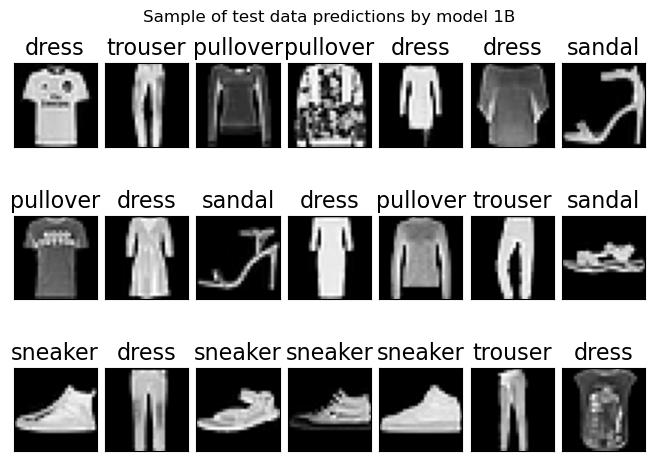

In [92]:
# Plot test data
rows = 3
cols = 7
fig, axgrid = plt.subplots(rows, cols, layout="constrained")

for imageID in range(rows*cols):
    ax = axgrid[np.unravel_index( imageID, (rows,cols))]
    x_SS = x_te[imageID].reshape((28,28))
    ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
    label = pred_te[imageID]
    ax.set_title(label, fontsize=16)
# plt.tight_layout();
fig.suptitle("Sample of test data predictions by model 1B")
plt.show();

In [ ]:
# TODO refine search using gridsearchcv

In [ ]:
# When refit is true we can use the best_estimator_ method, but this doesn't work with refit=false - here we need to manually run a fit on our training set.

# best_est_1 = fashion_pipes['rand_search'].best_estimator_

# pred_tr = best_est_1.predict(x_tr)
# pred_va = best_est_1.predict(x_va)
# pred_te = best_est_1.predict(x_te)

# # Save output of prediction on test data to a file.
# np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')
# sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True)

Ignore for the time being - this was done with refit = true, which fits the final model from randomizedSearchCV onto the entire dataset (tr+val).

![Balanced acc of 1.0 or tr and val](best_estimator_1.png)


# Repeat with data normalized

In [69]:
# normalize data - necessary
x_tr_norm = x_tr /255
x_va_norm = x_va /255


(2, 1)

In [93]:
# Combine training and validation datasets
x_all_norm = np.vstack((x_tr_norm,x_va_norm))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr_norm.shape, x_va_norm.shape, x_all_norm.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


In [94]:
param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

fashion_pipes_norm = sklearn.pipeline.Pipeline([
    ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1, refit=False))
])

fashion_pipes_norm.fit(x_all_norm, y_all_df['class_name'])

Pipeline(steps=[('rand_search',
                 RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                                    error_score='raise',
                                    estimator=MLPClassifier(early_stopping=True,
                                                            random_state=0,
                                                            solver='lbfgs'),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'activation': ['relu',
                                                                        'logistic',
                                                                        'identity',
                                                                        'tanh'],
                                                         'hidden_layer_sizes': [(20,),
                                                                                (50,),
                                                                                (100,),
                                                                                (200,),
                                                                                (500,)],
                                                         'le...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
                                    random_state=0, refit=False,
                                    return_train_score=True,
                                    scoring='balanced_accuracy'))])

In [95]:
# Assess the same procedure with normalized input data - same results and same accuracy found in this case.display

gridRes = fashion_pipes['rand_search'].cv_results_

display(gridRes)
bestIdxNorm = fashion_pipes['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
bestParams[0] = {k:v[bestIdxs[0]] for k,v in gridRes.items()}
bestParams[1] = {k:v[bestIdxs[1]] for k,v in gridRes.items()}
bestParams[2] = {k:v[bestIdxs[2]] for k,v in gridRes.items()}

display(bestParams)
# print(gridRes["mean_test_score"])
# display(gridRes["mean_test_score"])

{'mean_fit_time': array([ 11.83397031,  12.14979863,  52.8481946 ,  11.10986662,
          6.9161706 ,   6.5183866 ,  83.4761374 ,   6.36173415,
         14.23174715,  15.14547944,   4.18769121,   8.34587407,
         85.5971868 ,  12.78518701,  18.13360095,  76.21076941,
         89.98751068,  24.28821158,  53.94894862,   9.5179069 ,
         30.74120164,  25.26397276,  28.51192164,  15.52358723,
         28.83713508,   7.37694645,   9.93362951,  11.96822357,
         52.32941508,  58.75840545,  85.02098513,   7.38901854,
         14.54729462,  18.83104253,  15.59761214,  88.50252295,
          6.98106933,  34.44434738,  34.6710465 ,  68.56448483,
          3.5734458 , 144.78085947,  33.55686831,  20.76200438,
         86.58892202,  61.69820952, 138.82236099,  43.78358626,
         31.2854929 ,  73.24630141,  21.0114212 ,   7.07270598,
         22.96546125, 173.36207199,  23.01018333,  15.45958519,
          8.10864615, 166.55739093,   4.91688371,  24.87617588,
          6.75275135, 1

In [96]:
bestMLP1bNorm = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
bestMLP1bNorm.fit(x_tr_norm,y_tr_df["class_name"])

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(500,), learning_rate_init=1e-05,
              random_state=0, solver='lbfgs')

In [97]:
tr_acc = sklearn.metrics.balanced_accuracy_score(y_tr_df['class_name'], bestMLP1bNorm.predict(x_tr_norm))
va_acc = sklearn.metrics.balanced_accuracy_score(y_va_df['class_name'], bestMLP1bNorm.predict(x_va_norm))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

Training balanced accuracy: 1.000000
Validation balanced accuracy: 0.625000


For some reason the validation accuracy seems to be lower on normalized data

In [13]:
print(best_est_1)

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(500,), learning_rate_init=1e-05,
              random_state=0, solver='lbfgs')


# Model with Duplicate Data

In [10]:
#getting index for each class in training set:
top_int = y_tr_df.index[y_tr_df['class_name']=='top']    #index 1
trous_int = y_tr_df.index[y_tr_df['class_name']=='trouser']    #index 11
dress_int =(y_tr_df.index[y_tr_df['class_name']=='dress']).tolist()
pull_int =(y_tr_df.index[y_tr_df['class_name']=='pullover']).tolist()
sneaker_int =(y_tr_df.index[y_tr_df['class_name']=='sneaker']).tolist()
sandal_int =(y_tr_df.index[y_tr_df['class_name']=='sandal']).tolist()


#sneakers + sandals + tops + trous + dress + pullovers in new dataset.
train_x_2 = np.vstack((x_tr[sandal_int, :], x_tr[sneaker_int, :]))
tops800= np.tile(x_tr[top_int, :], (800, 1)) #make 800 copies of tops
train_x_2 = np.vstack((train_x_2, tops800)) # add 800 tops to sandals + sneakers
assert(train_x_2.shape == (2400, 784))  #checking dimensions

trous800 = np.tile(x_tr[trous_int, :], (800, 1))  #800 copies of trousers
train_x_2 = np.vstack((train_x_2, trous800)) # add 800 trousers
assert(train_x_2.shape == (3200, 784))  #checking dimensions

dress800 = np.tile(x_tr[dress_int, :], (2, 1))   #doubled dresses 400 to 800
assert(dress800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, dress800)) # add 800 dresses
assert(train_x_2.shape == (4000, 784))  #checking dimensions

pull800 = np.tile(x_tr[pull_int, :], (8, 1))
assert(pull800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, pull800)) # add 800 dresses
assert(train_x_2.shape == (4800, 784))

#making train_y_2
train_y_2 = np.tile(7, 800) 
train_y_2 = np.hstack((train_y_2, np.tile(5, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(0, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(1, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(3, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(2, 800)))

assert(train_y_2.shape == (4800, ))


In [17]:
# Combine training and validation datasets
x_dup_all = np.vstack((train_x_2, x_va))
y_dup_all = np.hstack((train_y_2, y_va_df['class_uid']))

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (train_x_2.shape, x_va.shape, x_dup_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (train_y_2.shape, y_va_df['class_uid'].shape, y_dup_all.shape))

valid_dup_indicators = np.hstack([
    -1 * np.ones(train_y_2.shape[0]), #-1 = exclude this example in test split
    0 * np.ones(y_va_df.shape[0]), #0 = include in the first test split
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_dup_indicators.shape[0]))
my_dup_splitter = sklearn.model_selection.PredefinedSplit(valid_dup_indicators)

Training X shape: (4800, 784)
Validation X shape: (600, 784)
Combined X shape: (5400, 784)

Training Y shape: (4800,)
Validation Y shape: (600,)
Combined Y shape: (5400,)

Splitter dimensions: 5400


In [29]:
param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

dup_fashion_pipes = sklearn.pipeline.Pipeline([
    ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier     (solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_dup_splitter, n_jobs = -1, refit= False))
])

dup_fashion_pipes.fit(x_dup_all, y_dup_all)


c:\Users\leigh\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('rand_search',
                 RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                                    error_score='raise',
                                    estimator=MLPClassifier(activation='identity',
                                                            early_stopping=True,
                                                            random_state=0,
                                                            solver='lbfgs'),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'activation': ['relu',
                                                                        'logistic',
                                                                        'identity',
                                                                        'tanh'],
                                                         'hidden_layer_sizes': [(20,),
                                                                                (50,),
                                                                                (10...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
                                    random_state=0, return_train_score=True,
                                    scoring='balanced_accuracy'))])

In [28]:
best_est_dup = dup_fashion_pipes['rand_search'].best_estimator_
print(best_est_dup)

dup_fashion_pipes['rand_search'].cv_results_

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(20,), learning_rate_init=12328.467394420633,
              random_state=0, solver='lbfgs')


{'mean_fit_time': array([  7.90431666,   5.68885159,   6.74163342, 136.73479891,
        147.51664948,   6.75769186, 192.97910023, 137.85547805,
          4.54995203,   4.92334962,   5.67320871,   6.75769186,
        154.42929387,   6.67853761,   3.32916641,  93.34185719,
        167.19892764, 113.08569884,   4.58963537,   8.19217563,
          7.44723296, 131.22171521,   6.34882593,   5.9001677 ,
          9.2323122 , 138.49407721,   8.55011559, 276.09204555,
          6.44989014,   5.9444716 , 139.07542181,   4.04504943,
          4.08124852,   4.04780507,  91.80869937, 161.01453185,
        104.79370284, 149.02405357,  95.11436343,   9.20697594,
        109.60525227,   6.4690485 , 166.36215711,   5.81573009,
          6.50672436,   9.26218033,   5.93299007,  91.10143542,
        158.71967673,   5.66637969,  99.42205715,   5.79916835,
        106.27263522,   3.70691252,   3.86656833,   8.50867701,
        120.10436988,   3.61238313,   6.12883568, 185.73284411,
          6.62986445,  

In [32]:
filename = '1D_initial_search.sav'
pickle.dump(dup_fashion_pipes, open(filename, 'wb'))

In [23]:
pred_tr_dup = best_est_dup.predict(train_x_2)
pred_va_dup = best_est_dup.predict(x_va)
pred_te_dup = best_est_dup.predict(x_te)

print(best_est_dup.bal)


[5 7 5 ... 0 1 1]


In [60]:
ranks = dup_fashion_pipes['rand_search'].cv_results_['rank_test_score']
bests= np.argsort(ranks)[0:7]   #all index with rank 1.

for i in bests:
    print(dup_fashion_pipes['rand_search'].cv_results_['params'][i])

#best activation function is logistic with hidden layer 20. 
#both constant and adaptive learning did well:
    #for constant: learning rate init ranged from 0000.3 - 1917 range!
    #for adaptive: learning rate init range 8.11e-05 - 1.12


{'learning_rate_init': 0.0013219411484660286, 'learning_rate': 'constant', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 1917.910261672485, 'learning_rate': 'constant', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 8.111308307896872e-05, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 0.00032745491628777284, 'learning_rate': 'constant', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 0.008497534359086439, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 1.1233240329780265, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}
{'learning_rate_init': 0.017073526474706904, 'learning_rate': 'constant', 'hidden_layer_sizes': (20,), 'activation': 'logistic'}


In [ ]:
pred_tr_norm = bestMLP1bNorm.predict(x_tr_norm)
pred_va_norm = bestMLP1bNorm.predict(x_va_norm)
pred_te_norm = bestMLP1bNorm.predict(x_te/255)

# Save output of prediction on test data to a file.
np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')